In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, 
                                     GaussianNoise, Input, MaxPool2D, Reshape, SeparableConv2D, SpatialDropout2D, 
                                     UpSampling2D, ZeroPadding2D)

In [180]:
def convert_to_batches(data, batch_size=8):
    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=100)
    return dataset.batch(batch_size, drop_remainder=True).prefetch(1)
def normalize(X):
    X = X/255
    X = X * 2. - 1.
    return X
def denormalize(X):
    X = (X + 1.) / 2
    X = X * 255
    return X

In [194]:
norm = [[], []]
deno = [[], []]
regu = [[], []]
for i in range(-256, 256):
    norm[0].append(i)
    norm[1].append(normalize(i))
    deno[0].append(i)
    deno[1].append(denormalize(i))
    regu[0].append(i)
    regu[1].append(denormalize(normalize(i)))

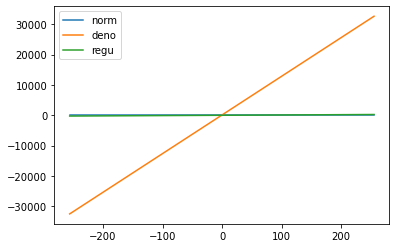

In [197]:
plt.plot(norm[0], norm[1], label='norm')
plt.plot(deno[0], deno[1], label='deno')
plt.plot(regu[0], regu[1], label='regu')
plt.legend()
plt.show()

In [202]:
np.array(regu)

array([[-256., -255., -254., ...,  253.,  254.,  255.],
       [-256., -255., -254., ...,  253.,  254.,  255.]])

In [297]:
# AUTO Encoder Network
def encoder(input_shape:tuple):
    model = Sequential(name='encoder')
    model.add(Input(shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1)))
    model.add(MaxPool2D())
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1)))
    model.add(MaxPool2D())
    model.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1)))
    model.add(MaxPool2D())
    model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Conv2D(2, kernel_size=(3, 3), strides=(1, 1)))
    model.build()
    model.summary()
    return model

def decoder(input_shape:tuple):
    model = Sequential(name='decoder')
    model.add(Input(shape=input_shape))
    model.add(Conv2DTranspose(2, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Conv2DTranspose(4, kernel_size=(3, 3), strides=(1, 1)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(8, kernel_size=(3, 3), strides=(1, 1)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(1, 1)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(1, 1)))
    model.build()
    model.summary()
    return model

# GAN Network
def generator(input_shape:tuple):
    model = Sequential(name='generator')
    model.add(Input(shape=input_shape))
    model.add(Conv2DTranspose(2, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Conv2DTranspose(4, kernel_size=(3, 3), strides=(1, 1)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(8, kernel_size=(3, 3), strides=(1, 1)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(1, 1)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(1, 1)))
    return model

def discriminator(input_shape:tuple):
    model = Sequential(name='discriminator')
    model.add(Input(shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(MaxPool2D())
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1)))
    model.add(MaxPool2D())
    model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1)))
    model.add(MaxPool2D())
    model.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1)))
    model.add(MaxPool2D())
    model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Conv2D(2, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.trainable = False
    return model

def gan(generator, generator_input_shape:tuple, discriminator, discriminator_input_shape:tuple):
    model = Sequential([generator(generator_input_shape), discriminator(discriminator_input_shape)])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [298]:
def train_gan(model, epochs, dataset, input_shape, image_shape, batch_size):

    for epoch in range(epochs):
        print(f'Currently on Epoch {epoch+1}')

        for i, X_batch in enumerate(dataset):
            i += 1
#             if i % 100 == 0:
            print(f'\t Currently on batch number {i} of {len(dataset)}')

            # DISCRIMINATOR Training Phase
            noise = tf.random.normal(shape=[batch_size] + input_shape)
            gen_image = model.layers[0](noise)
            X_fake_vs_real = tf.concat([gen_image, tf.dtypes.cast(X_batch, tf.float32)], axis=0)
            y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
            model.layers[1].trainable = True
            model.layers[1].train_on_batch(X_fake_vs_real, y1)

            # GENERATOR Training Phase
            noise = tf.random.normal(shape=[batch_size] + input_shape)
            y2 = tf.constant([[1.0]] * batch_size)
            model.layers[1].trainable = False
            GAN.train_on_batch(noise, y2)

In [299]:
image_shape = (128, 128, 3)
GAN = gan(generator, (2, 2, 2), discriminator, image_shape)
GAN.layers[0].summary()
GAN.layers[1].summary()
e = encoder(image_shape)
d = decoder((2, 2, 2))

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_315 (Conv2D (None, 4, 4, 2)           38        
_________________________________________________________________
conv2d_transpose_316 (Conv2D (None, 6, 6, 4)           76        
_________________________________________________________________
up_sampling2d_185 (UpSamplin (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_transpose_317 (Conv2D (None, 14, 14, 8)         296       
_________________________________________________________________
up_sampling2d_186 (UpSamplin (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_transpose_318 (Conv2D (None, 30, 30, 16)        1168      
_________________________________________________________________
up_sampling2d_187 (UpSamplin (None, 60, 60, 16)        0 

In [300]:
len(data)

127

In [310]:
train_gan(GAN, 19, data, list((2, 2, 2)), list(image_shape), 8)

Currently on Epoch 1
	 Currently on batch number 1 of 127
	 Currently on batch number 2 of 127
	 Currently on batch number 3 of 127
	 Currently on batch number 4 of 127
	 Currently on batch number 5 of 127
	 Currently on batch number 6 of 127
	 Currently on batch number 7 of 127
	 Currently on batch number 8 of 127
	 Currently on batch number 9 of 127
	 Currently on batch number 10 of 127
	 Currently on batch number 11 of 127
	 Currently on batch number 12 of 127
	 Currently on batch number 13 of 127
	 Currently on batch number 14 of 127
	 Currently on batch number 15 of 127
	 Currently on batch number 16 of 127
	 Currently on batch number 17 of 127
	 Currently on batch number 18 of 127
	 Currently on batch number 19 of 127
	 Currently on batch number 20 of 127
	 Currently on batch number 21 of 127
	 Currently on batch number 22 of 127
	 Currently on batch number 23 of 127
	 Currently on batch number 24 of 127
	 Currently on batch number 25 of 127
	 Currently on batch number 26 of 127


	 Currently on batch number 89 of 127
	 Currently on batch number 90 of 127
	 Currently on batch number 91 of 127
	 Currently on batch number 92 of 127
	 Currently on batch number 93 of 127
	 Currently on batch number 94 of 127
	 Currently on batch number 95 of 127
	 Currently on batch number 96 of 127
	 Currently on batch number 97 of 127
	 Currently on batch number 98 of 127
	 Currently on batch number 99 of 127
	 Currently on batch number 100 of 127
	 Currently on batch number 101 of 127
	 Currently on batch number 102 of 127
	 Currently on batch number 103 of 127
	 Currently on batch number 104 of 127
	 Currently on batch number 105 of 127
	 Currently on batch number 106 of 127
	 Currently on batch number 107 of 127
	 Currently on batch number 108 of 127
	 Currently on batch number 109 of 127
	 Currently on batch number 110 of 127
	 Currently on batch number 111 of 127
	 Currently on batch number 112 of 127
	 Currently on batch number 113 of 127
	 Currently on batch number 114 of 1

	 Currently on batch number 49 of 127
	 Currently on batch number 50 of 127
	 Currently on batch number 51 of 127
	 Currently on batch number 52 of 127
	 Currently on batch number 53 of 127
	 Currently on batch number 54 of 127
	 Currently on batch number 55 of 127
	 Currently on batch number 56 of 127
	 Currently on batch number 57 of 127
	 Currently on batch number 58 of 127
	 Currently on batch number 59 of 127
	 Currently on batch number 60 of 127
	 Currently on batch number 61 of 127
	 Currently on batch number 62 of 127
	 Currently on batch number 63 of 127
	 Currently on batch number 64 of 127
	 Currently on batch number 65 of 127
	 Currently on batch number 66 of 127
	 Currently on batch number 67 of 127
	 Currently on batch number 68 of 127
	 Currently on batch number 69 of 127
	 Currently on batch number 70 of 127
	 Currently on batch number 71 of 127
	 Currently on batch number 72 of 127
	 Currently on batch number 73 of 127
	 Currently on batch number 74 of 127
	 Currently 

	 Currently on batch number 9 of 127
	 Currently on batch number 10 of 127
	 Currently on batch number 11 of 127
	 Currently on batch number 12 of 127
	 Currently on batch number 13 of 127
	 Currently on batch number 14 of 127
	 Currently on batch number 15 of 127
	 Currently on batch number 16 of 127
	 Currently on batch number 17 of 127
	 Currently on batch number 18 of 127
	 Currently on batch number 19 of 127
	 Currently on batch number 20 of 127
	 Currently on batch number 21 of 127
	 Currently on batch number 22 of 127
	 Currently on batch number 23 of 127
	 Currently on batch number 24 of 127
	 Currently on batch number 25 of 127
	 Currently on batch number 26 of 127
	 Currently on batch number 27 of 127
	 Currently on batch number 28 of 127
	 Currently on batch number 29 of 127
	 Currently on batch number 30 of 127
	 Currently on batch number 31 of 127
	 Currently on batch number 32 of 127
	 Currently on batch number 33 of 127
	 Currently on batch number 34 of 127
	 Currently o

	 Currently on batch number 97 of 127
	 Currently on batch number 98 of 127
	 Currently on batch number 99 of 127
	 Currently on batch number 100 of 127
	 Currently on batch number 101 of 127
	 Currently on batch number 102 of 127
	 Currently on batch number 103 of 127
	 Currently on batch number 104 of 127
	 Currently on batch number 105 of 127
	 Currently on batch number 106 of 127
	 Currently on batch number 107 of 127
	 Currently on batch number 108 of 127
	 Currently on batch number 109 of 127
	 Currently on batch number 110 of 127
	 Currently on batch number 111 of 127
	 Currently on batch number 112 of 127
	 Currently on batch number 113 of 127
	 Currently on batch number 114 of 127
	 Currently on batch number 115 of 127
	 Currently on batch number 116 of 127
	 Currently on batch number 117 of 127
	 Currently on batch number 118 of 127
	 Currently on batch number 119 of 127
	 Currently on batch number 120 of 127
	 Currently on batch number 121 of 127
	 Currently on batch number 

	 Currently on batch number 57 of 127
	 Currently on batch number 58 of 127
	 Currently on batch number 59 of 127
	 Currently on batch number 60 of 127
	 Currently on batch number 61 of 127
	 Currently on batch number 62 of 127
	 Currently on batch number 63 of 127
	 Currently on batch number 64 of 127
	 Currently on batch number 65 of 127
	 Currently on batch number 66 of 127
	 Currently on batch number 67 of 127
	 Currently on batch number 68 of 127
	 Currently on batch number 69 of 127
	 Currently on batch number 70 of 127
	 Currently on batch number 71 of 127
	 Currently on batch number 72 of 127
	 Currently on batch number 73 of 127
	 Currently on batch number 74 of 127
	 Currently on batch number 75 of 127
	 Currently on batch number 76 of 127
	 Currently on batch number 77 of 127
	 Currently on batch number 78 of 127
	 Currently on batch number 79 of 127
	 Currently on batch number 80 of 127
	 Currently on batch number 81 of 127
	 Currently on batch number 82 of 127
	 Currently 

	 Currently on batch number 17 of 127
	 Currently on batch number 18 of 127
	 Currently on batch number 19 of 127
	 Currently on batch number 20 of 127
	 Currently on batch number 21 of 127
	 Currently on batch number 22 of 127
	 Currently on batch number 23 of 127
	 Currently on batch number 24 of 127
	 Currently on batch number 25 of 127
	 Currently on batch number 26 of 127
	 Currently on batch number 27 of 127
	 Currently on batch number 28 of 127
	 Currently on batch number 29 of 127
	 Currently on batch number 30 of 127
	 Currently on batch number 31 of 127
	 Currently on batch number 32 of 127
	 Currently on batch number 33 of 127
	 Currently on batch number 34 of 127
	 Currently on batch number 35 of 127
	 Currently on batch number 36 of 127
	 Currently on batch number 37 of 127
	 Currently on batch number 38 of 127
	 Currently on batch number 39 of 127
	 Currently on batch number 40 of 127
	 Currently on batch number 41 of 127
	 Currently on batch number 42 of 127
	 Currently 

	 Currently on batch number 105 of 127
	 Currently on batch number 106 of 127
	 Currently on batch number 107 of 127
	 Currently on batch number 108 of 127
	 Currently on batch number 109 of 127
	 Currently on batch number 110 of 127
	 Currently on batch number 111 of 127
	 Currently on batch number 112 of 127
	 Currently on batch number 113 of 127
	 Currently on batch number 114 of 127
	 Currently on batch number 115 of 127
	 Currently on batch number 116 of 127
	 Currently on batch number 117 of 127
	 Currently on batch number 118 of 127
	 Currently on batch number 119 of 127
	 Currently on batch number 120 of 127
	 Currently on batch number 121 of 127
	 Currently on batch number 122 of 127
	 Currently on batch number 123 of 127
	 Currently on batch number 124 of 127
	 Currently on batch number 125 of 127
	 Currently on batch number 126 of 127
	 Currently on batch number 127 of 127
Currently on Epoch 13
	 Currently on batch number 1 of 127
	 Currently on batch number 2 of 127
	 Curre

	 Currently on batch number 65 of 127
	 Currently on batch number 66 of 127
	 Currently on batch number 67 of 127
	 Currently on batch number 68 of 127
	 Currently on batch number 69 of 127
	 Currently on batch number 70 of 127
	 Currently on batch number 71 of 127
	 Currently on batch number 72 of 127
	 Currently on batch number 73 of 127
	 Currently on batch number 74 of 127
	 Currently on batch number 75 of 127
	 Currently on batch number 76 of 127
	 Currently on batch number 77 of 127
	 Currently on batch number 78 of 127
	 Currently on batch number 79 of 127
	 Currently on batch number 80 of 127
	 Currently on batch number 81 of 127
	 Currently on batch number 82 of 127
	 Currently on batch number 83 of 127
	 Currently on batch number 84 of 127
	 Currently on batch number 85 of 127
	 Currently on batch number 86 of 127
	 Currently on batch number 87 of 127
	 Currently on batch number 88 of 127
	 Currently on batch number 89 of 127
	 Currently on batch number 90 of 127
	 Currently 

	 Currently on batch number 25 of 127
	 Currently on batch number 26 of 127
	 Currently on batch number 27 of 127
	 Currently on batch number 28 of 127
	 Currently on batch number 29 of 127
	 Currently on batch number 30 of 127
	 Currently on batch number 31 of 127
	 Currently on batch number 32 of 127
	 Currently on batch number 33 of 127
	 Currently on batch number 34 of 127
	 Currently on batch number 35 of 127
	 Currently on batch number 36 of 127
	 Currently on batch number 37 of 127
	 Currently on batch number 38 of 127
	 Currently on batch number 39 of 127
	 Currently on batch number 40 of 127
	 Currently on batch number 41 of 127
	 Currently on batch number 42 of 127
	 Currently on batch number 43 of 127
	 Currently on batch number 44 of 127
	 Currently on batch number 45 of 127
	 Currently on batch number 46 of 127
	 Currently on batch number 47 of 127
	 Currently on batch number 48 of 127
	 Currently on batch number 49 of 127
	 Currently on batch number 50 of 127
	 Currently 

	 Currently on batch number 113 of 127
	 Currently on batch number 114 of 127
	 Currently on batch number 115 of 127
	 Currently on batch number 116 of 127
	 Currently on batch number 117 of 127
	 Currently on batch number 118 of 127
	 Currently on batch number 119 of 127
	 Currently on batch number 120 of 127
	 Currently on batch number 121 of 127
	 Currently on batch number 122 of 127
	 Currently on batch number 123 of 127
	 Currently on batch number 124 of 127
	 Currently on batch number 125 of 127
	 Currently on batch number 126 of 127
	 Currently on batch number 127 of 127
Currently on Epoch 18
	 Currently on batch number 1 of 127
	 Currently on batch number 2 of 127
	 Currently on batch number 3 of 127
	 Currently on batch number 4 of 127
	 Currently on batch number 5 of 127
	 Currently on batch number 6 of 127
	 Currently on batch number 7 of 127
	 Currently on batch number 8 of 127
	 Currently on batch number 9 of 127
	 Currently on batch number 10 of 127
	 Currently on batch n

	 Currently on batch number 73 of 127
	 Currently on batch number 74 of 127
	 Currently on batch number 75 of 127
	 Currently on batch number 76 of 127
	 Currently on batch number 77 of 127
	 Currently on batch number 78 of 127
	 Currently on batch number 79 of 127
	 Currently on batch number 80 of 127
	 Currently on batch number 81 of 127
	 Currently on batch number 82 of 127
	 Currently on batch number 83 of 127
	 Currently on batch number 84 of 127
	 Currently on batch number 85 of 127
	 Currently on batch number 86 of 127
	 Currently on batch number 87 of 127
	 Currently on batch number 88 of 127
	 Currently on batch number 89 of 127
	 Currently on batch number 90 of 127
	 Currently on batch number 91 of 127
	 Currently on batch number 92 of 127
	 Currently on batch number 93 of 127
	 Currently on batch number 94 of 127
	 Currently on batch number 95 of 127
	 Currently on batch number 96 of 127
	 Currently on batch number 97 of 127
	 Currently on batch number 98 of 127
	 Currently 

In [242]:
print(f'Encoder Shape{e(tf.random.normal((8, 128, 128, 3))).shape}\nDecoder Shape{d(tf.random.normal((8, 2, 2, 2))).shape}')

Encoder Shape(8, 2, 2, 2)
Decoder Shape(8, 128, 128, 3)


In [243]:
images = tf.random.normal((8, 128, 128, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


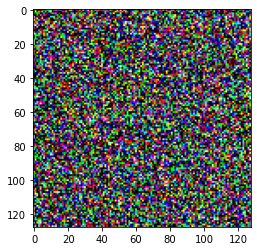

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


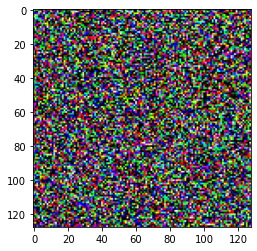

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


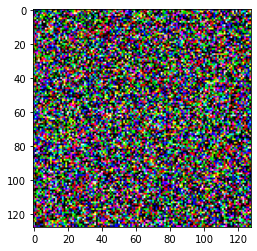

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


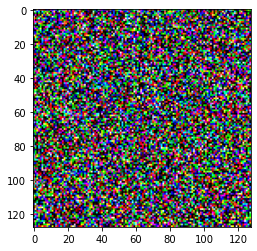

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


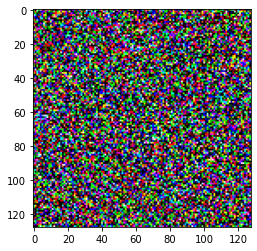

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


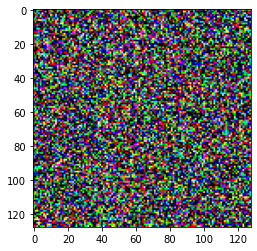

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


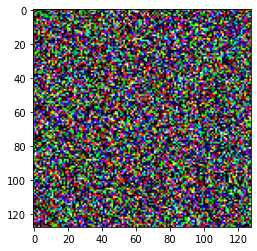

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


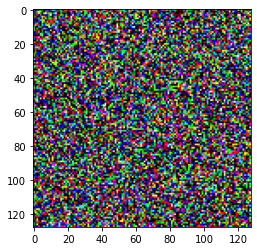

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


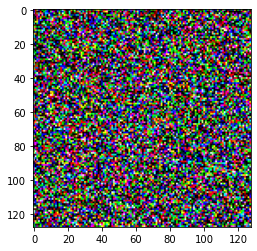

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


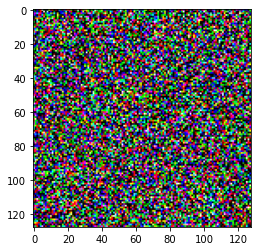

In [302]:
for image in images:
    plt.imshow(image)
    plt.show()

In [303]:
d(e(images)).shape

TensorShape([10, 128, 128, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


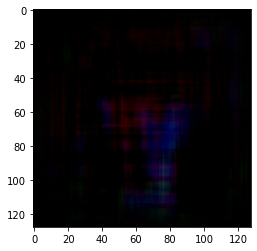

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


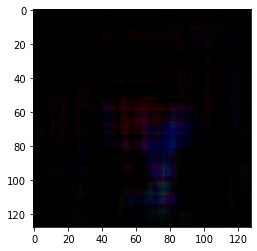

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


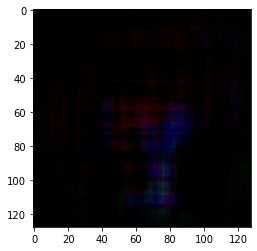

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


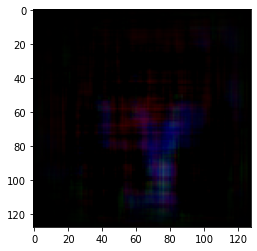

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


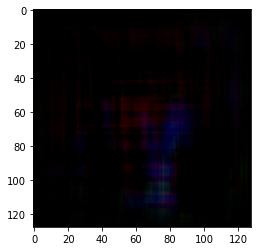

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


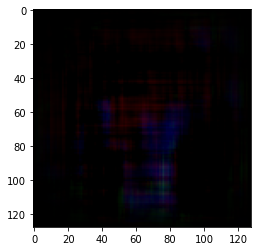

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


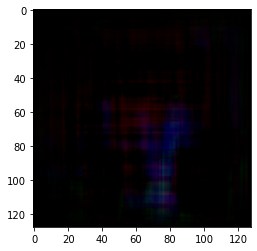

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


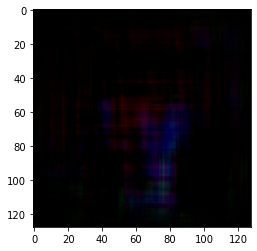

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


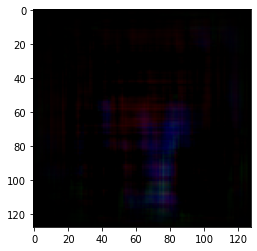

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


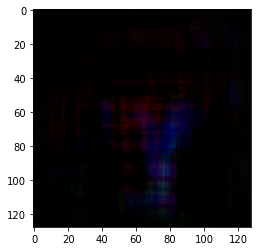

In [304]:
for image in d(e(images)):
    plt.imshow(image, cmap='gray')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


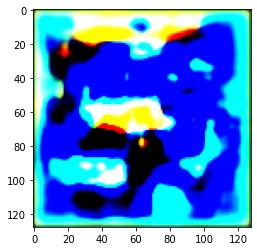

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


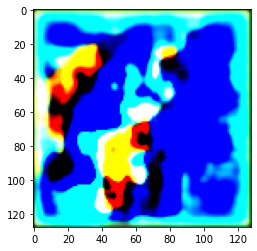

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


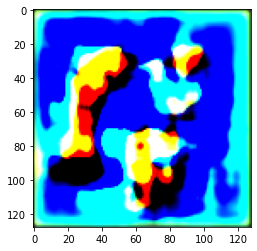

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


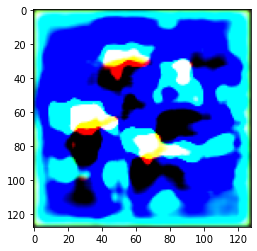

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


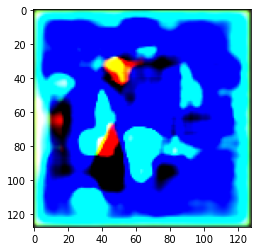

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


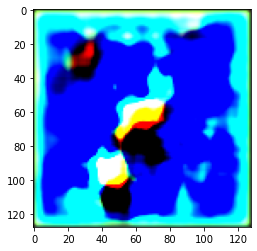

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


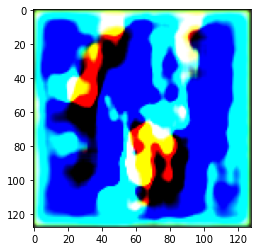

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


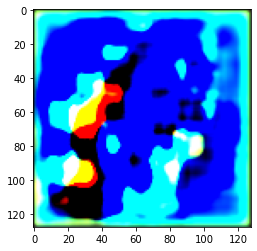

In [309]:
for image in GAN.layers[0](tf.random.normal((8, 2, 2, 2))):
    plt.imshow(image, cmap='gray')
    plt.show()

In [176]:
data_path = os.path.join(os.getcwd(), 'data/Sample001/')

In [224]:
X = []
for file in os.listdir(data_path):
    file = os.path.join(data_path, file)
    X.append(cv2.imread(file))
X = np.array(X)
# X = X[..., np.newaxis]

data = convert_to_batches(X)
c = 0
for _x in data:
    c += 1
print(c)
del _x, c

127


In [225]:
X.min()

0

In [226]:
X.max()

255

In [227]:
cv2.imread(file).min()

0

In [228]:
cv2.imread(file).max()

255

In [229]:
X.mean()

207.27920183797522

In [230]:
X.ndim

4

In [231]:
X.shape

(1016, 128, 128, 3)